In [37]:
import re
import sqlite3
import pandas as pd
import os
import shutil
import subprocess
import numpy as np
import pydicom
import matplotlib.pyplot as plt

In [141]:
DB_DIR = r"/nfs/MBSI/Osteoporosis/Head-CT/DB_filtered/BoneDensity_2023-03-01_10 - deid.db"
DICOM_DIR = r"/nfs/MBSI/Osteoporosis/Head-CT/DICOM_filtered/"  
TEMP_DIR = r"./temp"

connection = sqlite3.connect(DB_DIR)
BMD_tbl_Image_df = pd.read_sql_query("SELECT * FROM BMD_tbl_Image", connection)
BMD_tbl_Subject_df = pd.read_sql_query("SELECT * FROM BMD_tbl_Subject", connection)
BMD_tbl_Test_df = pd.read_sql_query("SELECT * FROM BMD_tbl_Test", connection)[["StudyInstanceUID", "SeriesInstanceUID"]]   

db = pd.merge(left=BMD_tbl_Subject_df, right=BMD_tbl_Test_df, on="StudyInstanceUID")
db = pd.merge(left=db, right=BMD_tbl_Image_df[["SeriesInstanceUID", "SOPInstanceUID", "InstanceNumber"]], on="SeriesInstanceUID")
db = db[["SubjectID", "StudyInstanceUID", "SeriesInstanceUID", "SOPInstanceUID"]]
db["Path"] = DICOM_DIR + db["SubjectID"] + "/" + db["SOPInstanceUID"] + ".dcm"
db = db.groupby(["SubjectID", "StudyInstanceUID", "SeriesInstanceUID"])["Path"].apply(list).reset_index(name="Paths")

In [156]:
row = db[db["SeriesInstanceUID"] == "3.6.16.8.8035.1.5.1.06039.55415629443542959258888566182"].iloc[0]

In [157]:
for path in row["Paths"]:
    shutil.copy(path, os.path.abspath(TEMP_DIR))

# subprocess.call(
#     (
#         "plastimatch",
#         "convert",
#         "--input", 
#         str(os.path.abspath(TEMP_DIR)),
#         "--output-img", 
#         str(os.path.abspath(os.path.join(TEMP_DIR, f"temp.nrrd"))),
#         "--algorithm", 
#         "itk",
#     )
# )

In [158]:
import nrrd
# data, header = nrrd.read("./temp/temp.nrrd")
# print(data.shape)

In [159]:
# for i in range(512):
#     for j in range(512):
#         if data[i, j, 0] != data[i, j, 1]:
#             print(i, j)
# data[0, 143, 0], data[0, 143, 1]

In [160]:
def data_reader(file_path: str) -> list:
    ct_scans = []
    for root, _, files in os.walk(os.path.abspath(file_path)):
        if len(files):
            files.sort()
            ct_scans.append([pydicom.dcmread(os.path.join(root, file)) for file in files if file.endswith(".dcm")])

    return ct_scans

ct_scan = data_reader(r"./temp/")[0]

In [161]:
ct_scan = sorted(ct_scan, key=lambda s: s.InstanceNumber, reverse=True)
print(len(ct_scan))

54


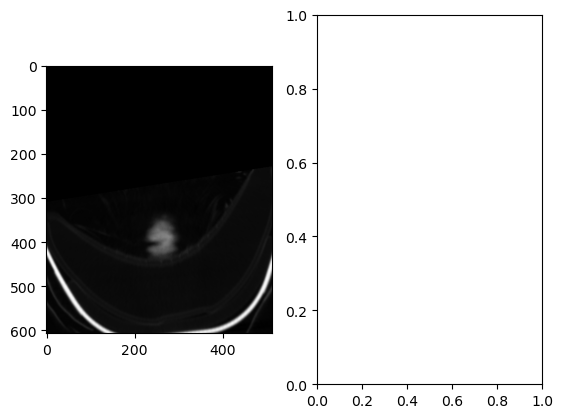

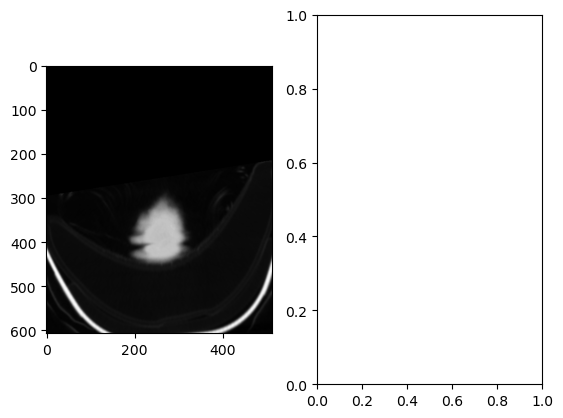

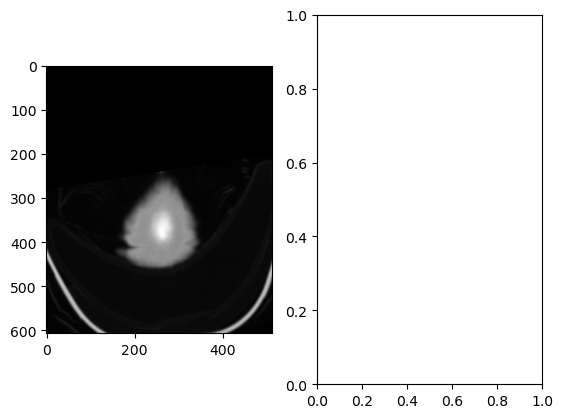

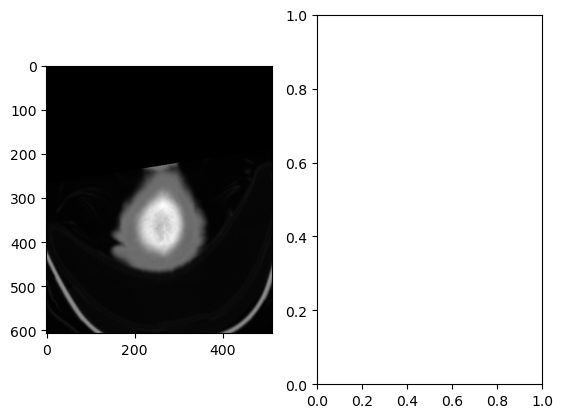

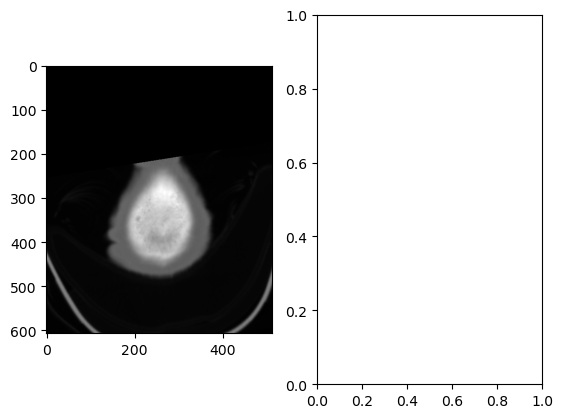

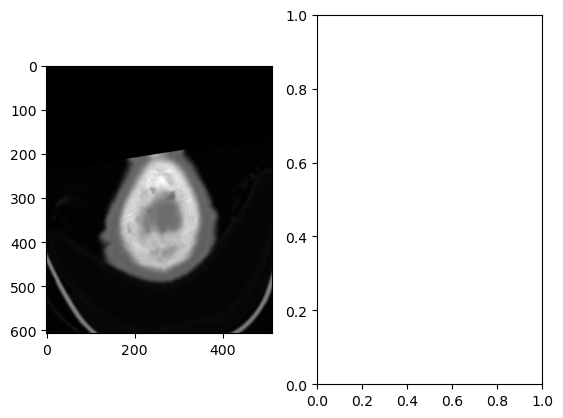

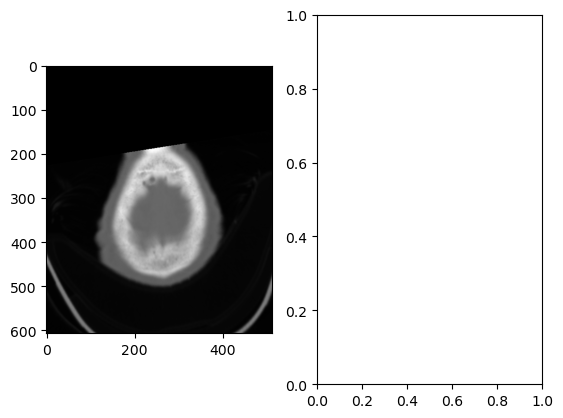

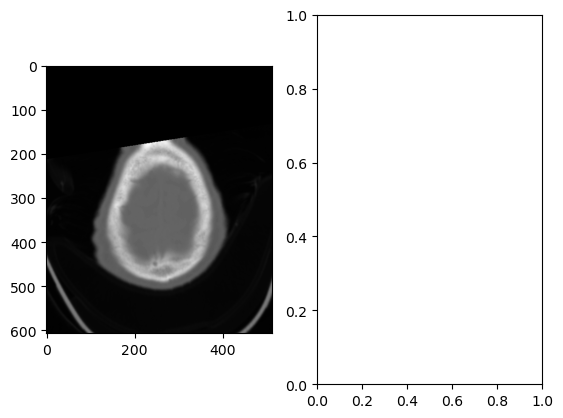

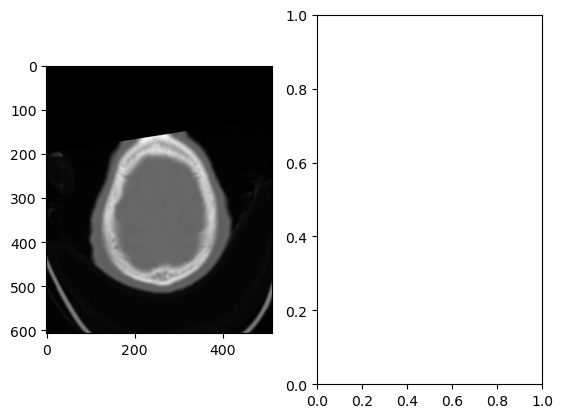

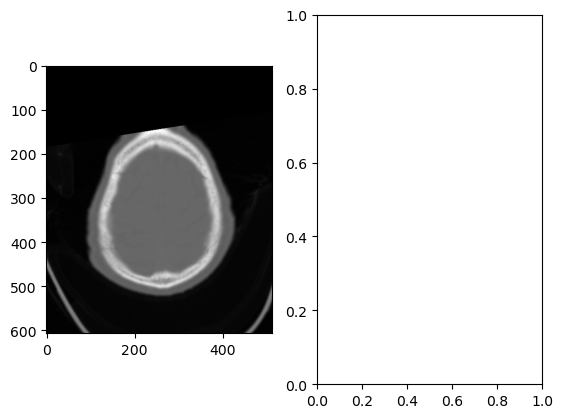

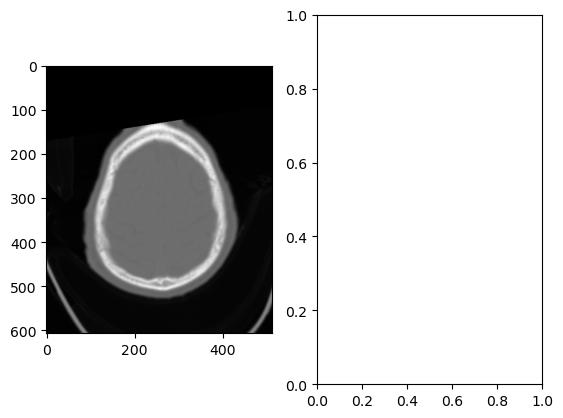

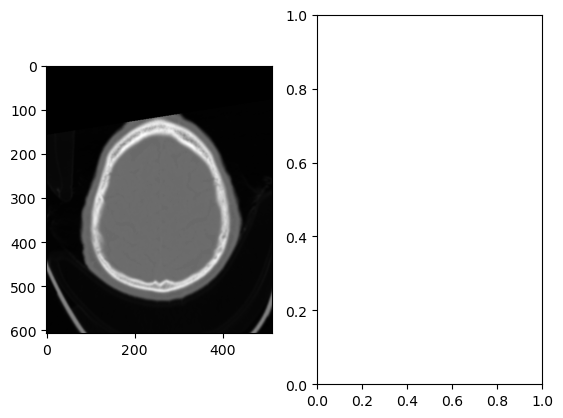

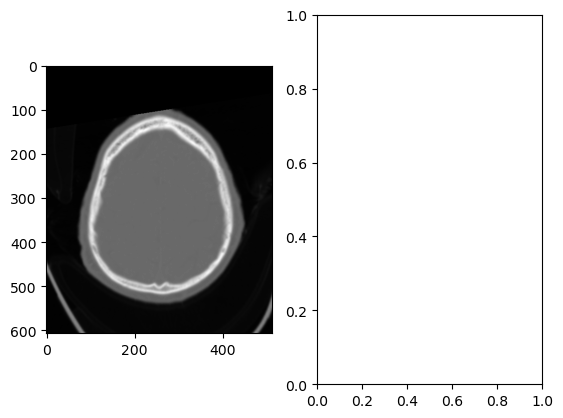

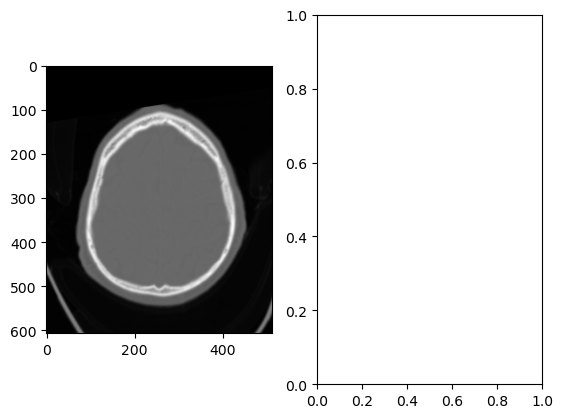

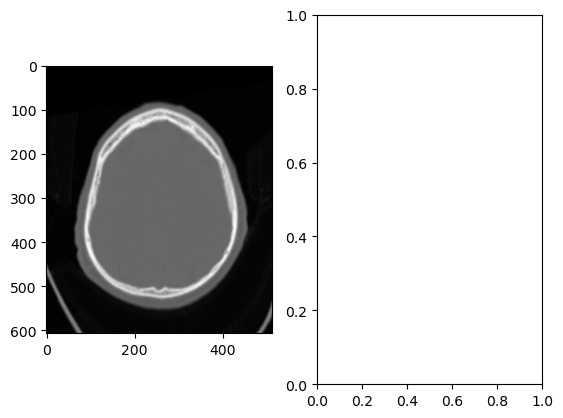

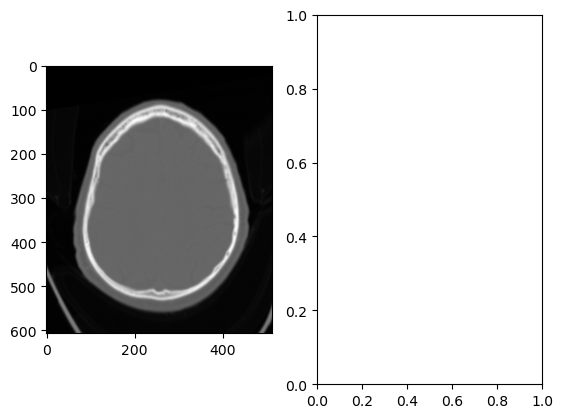

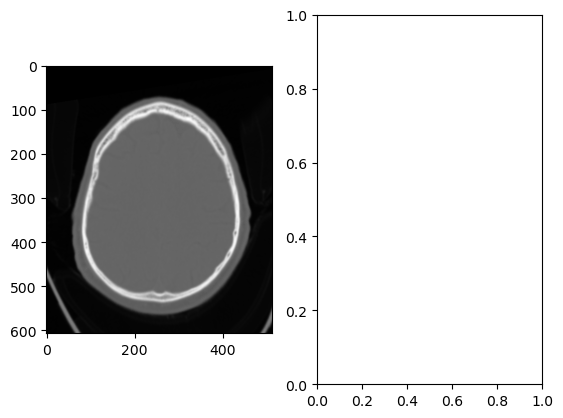

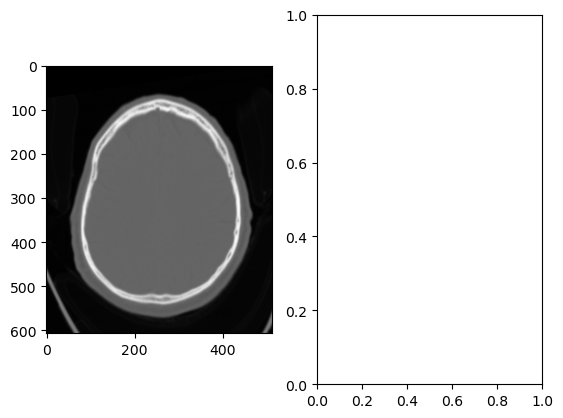

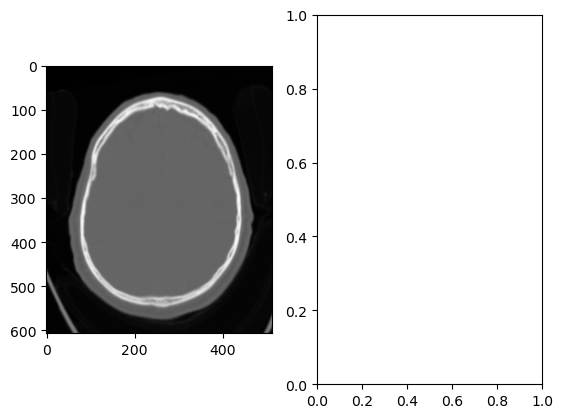

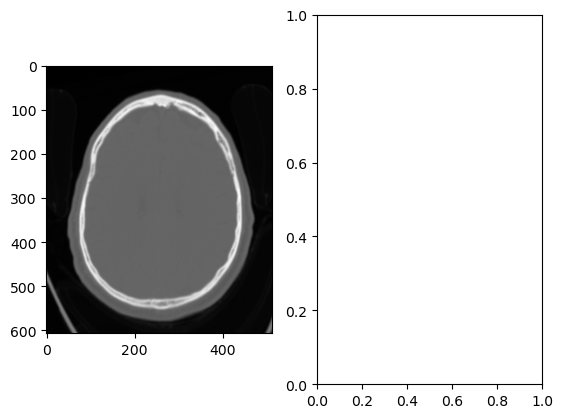

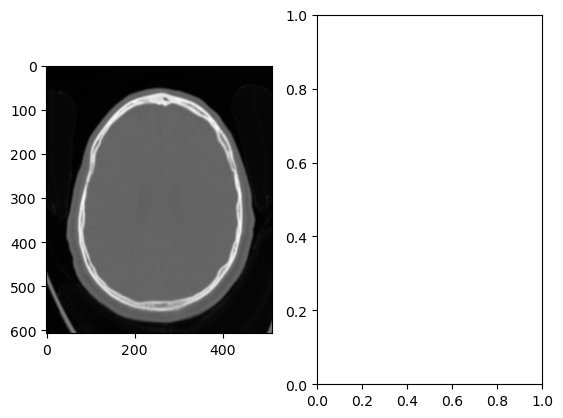

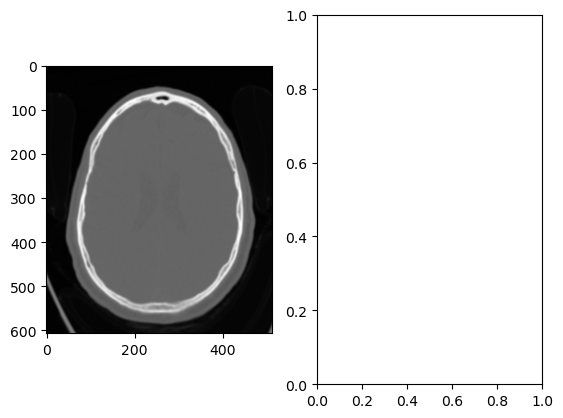

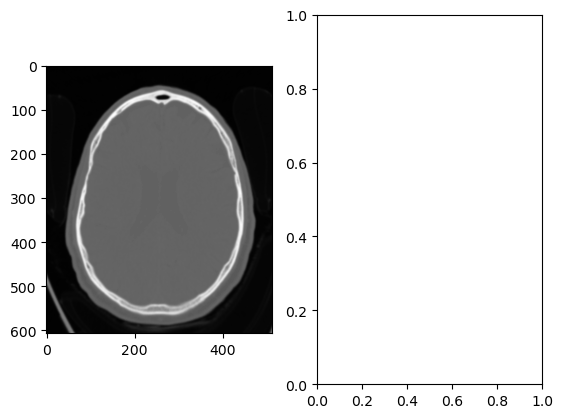

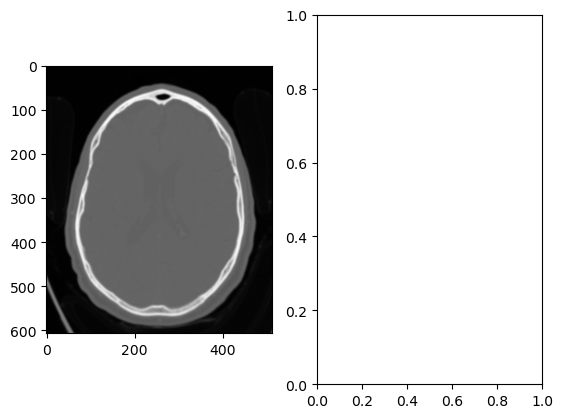

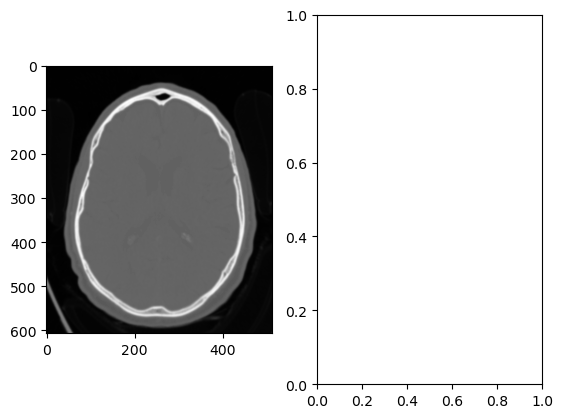

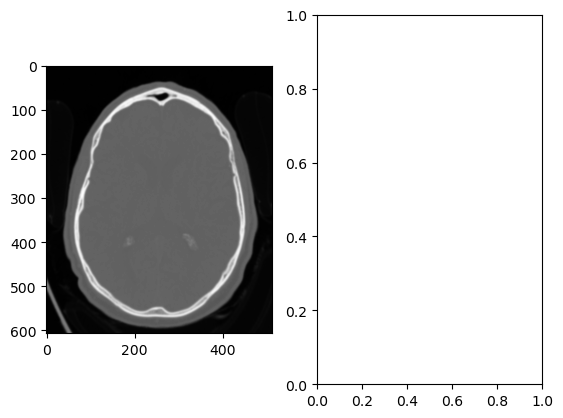

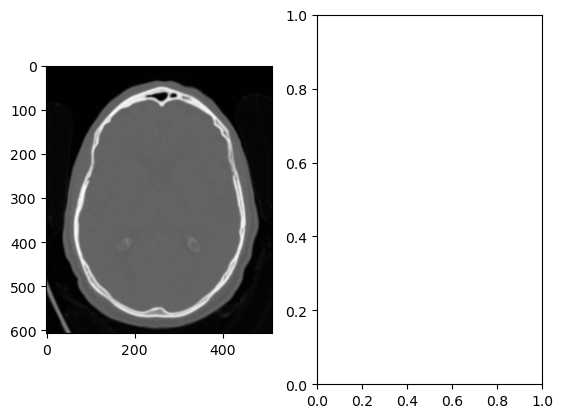

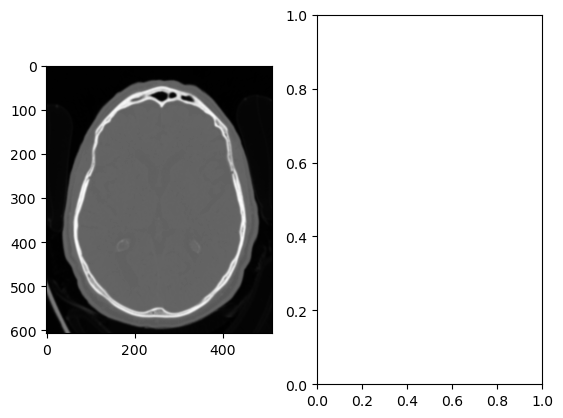

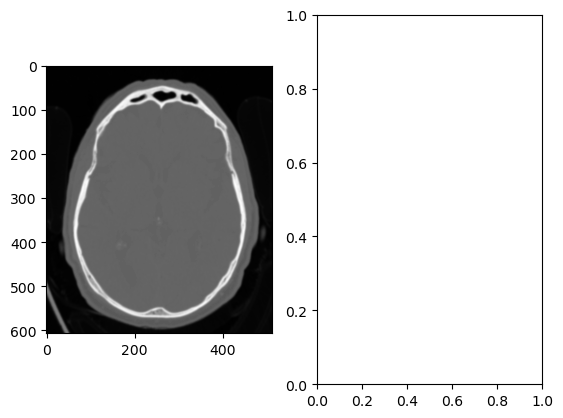

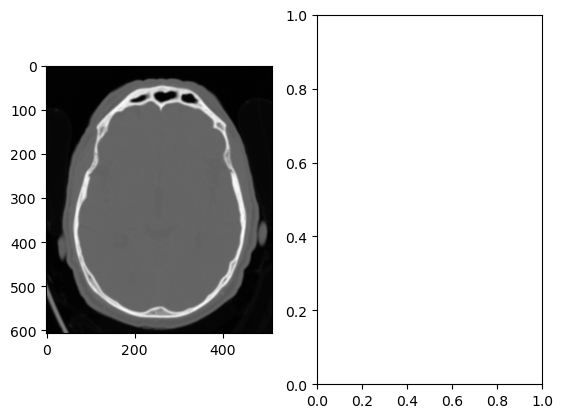

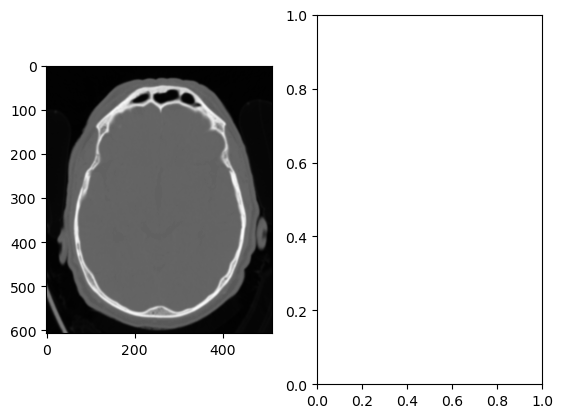

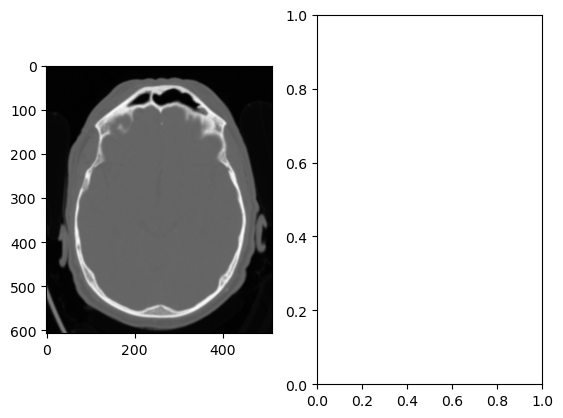

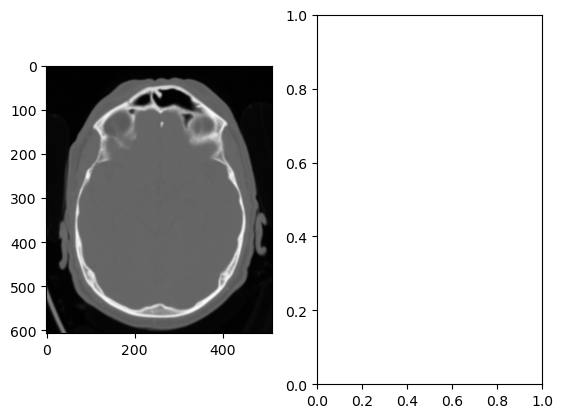

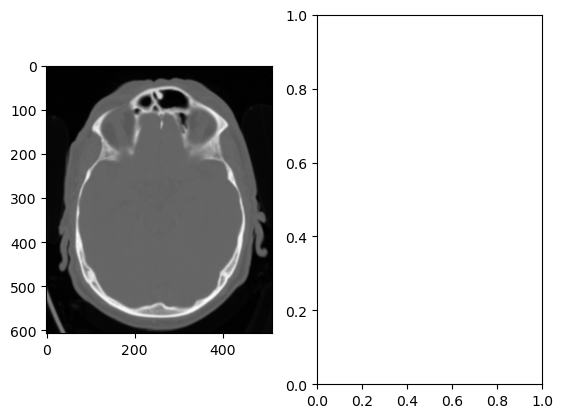

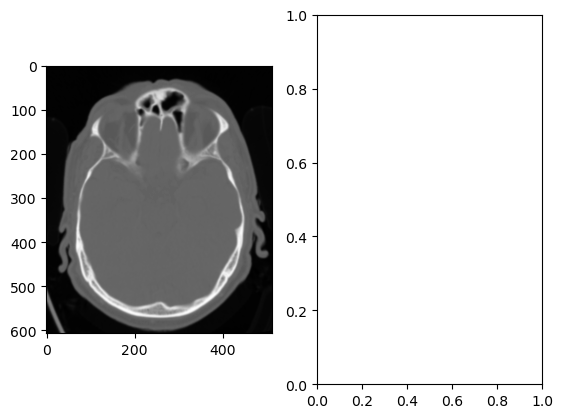

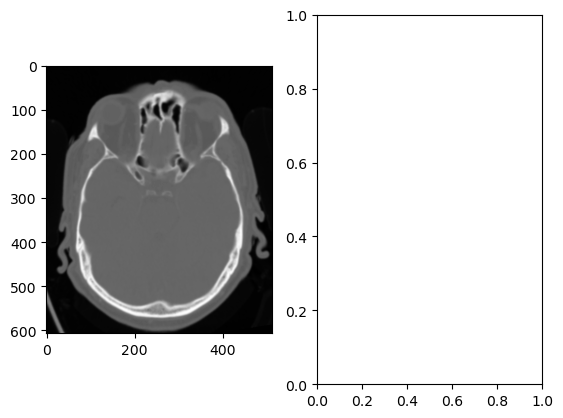

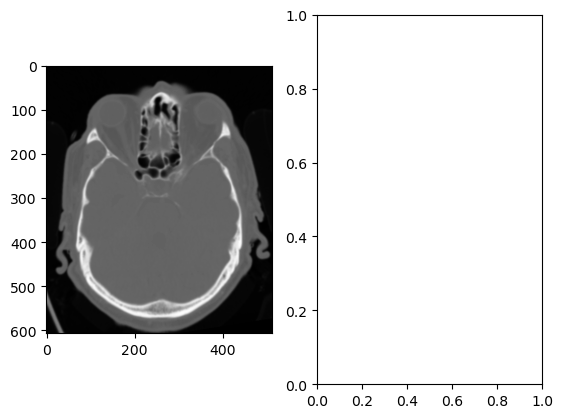

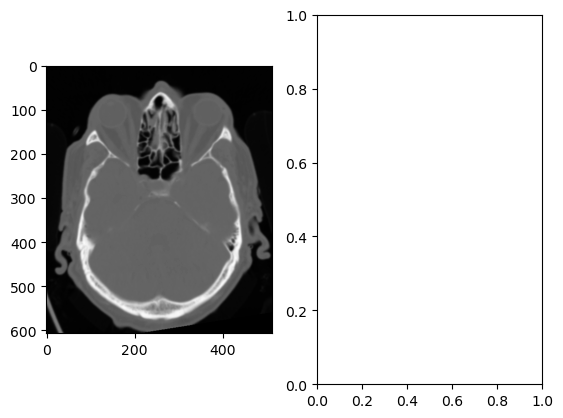

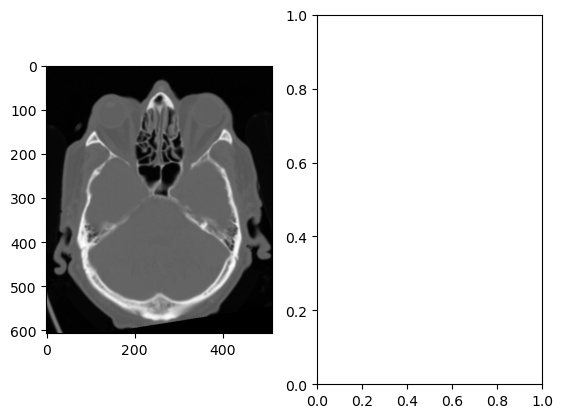

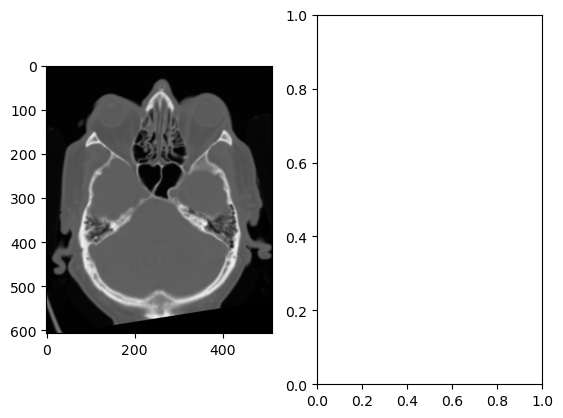

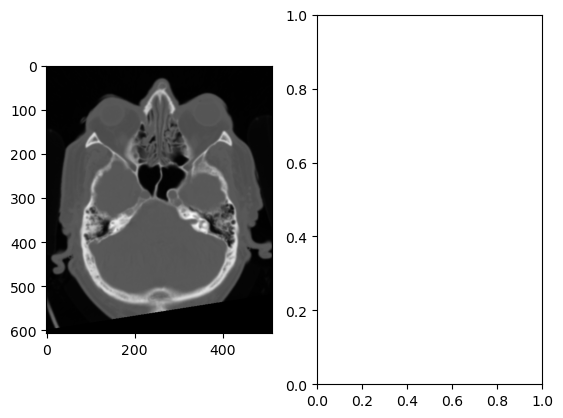

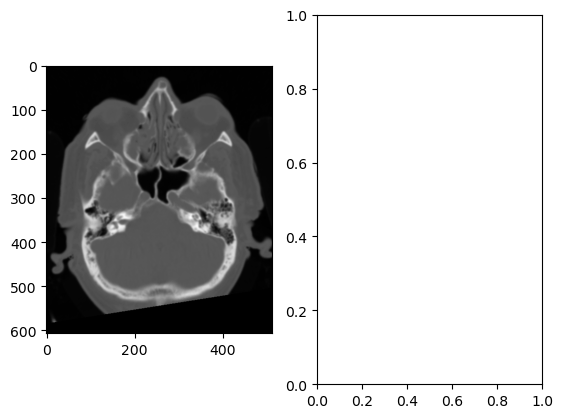

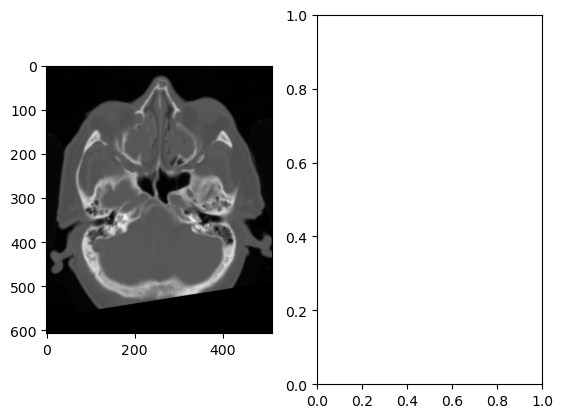

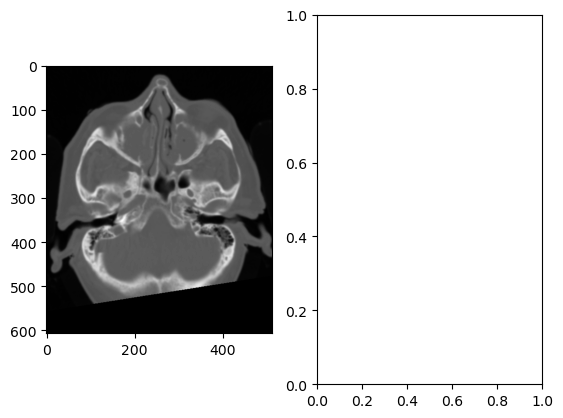

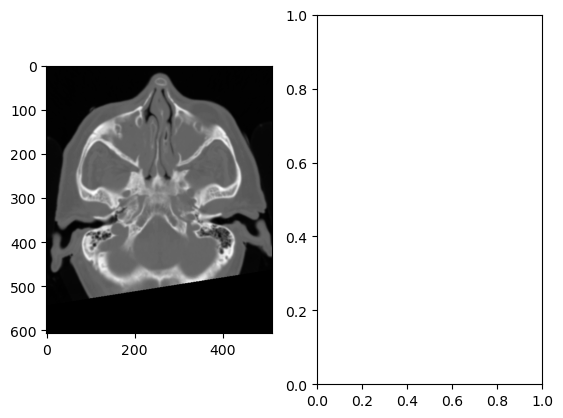

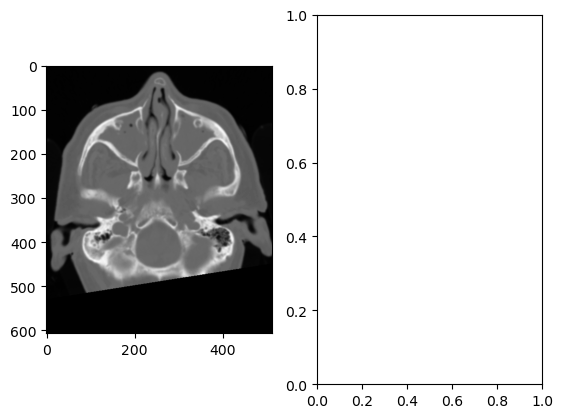

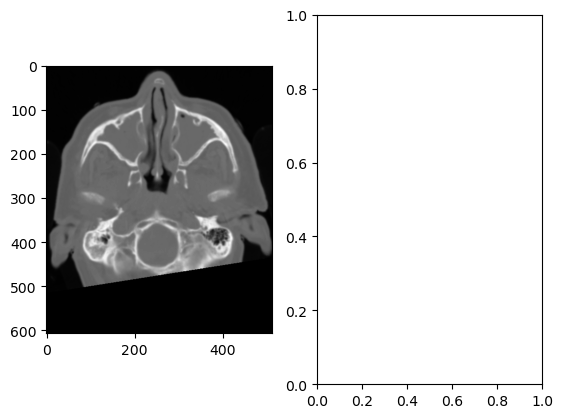

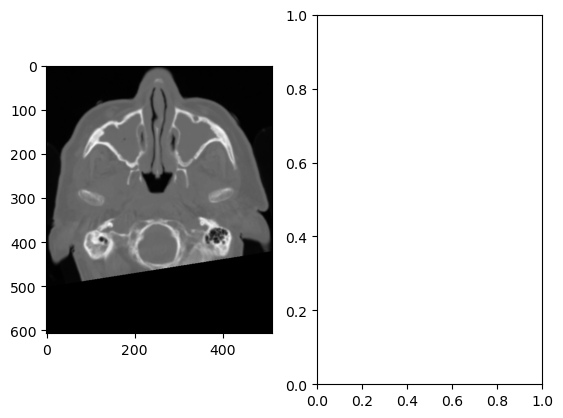

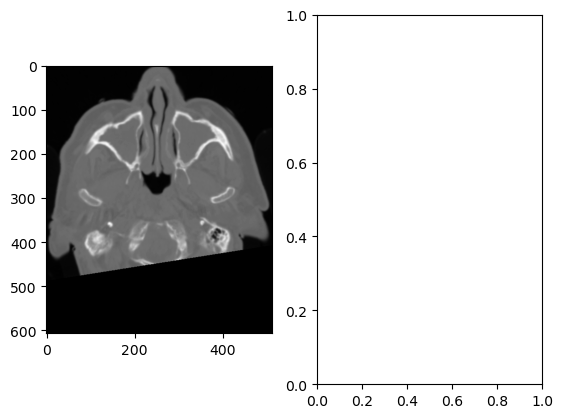

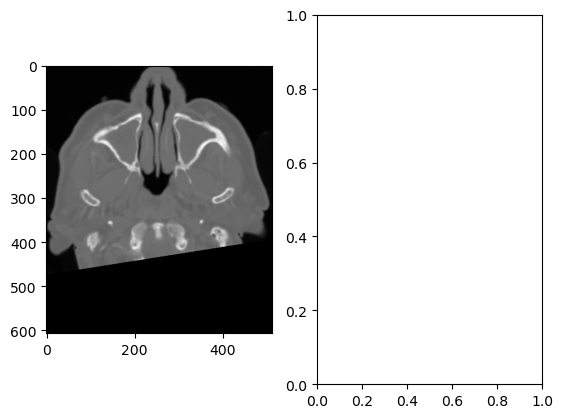

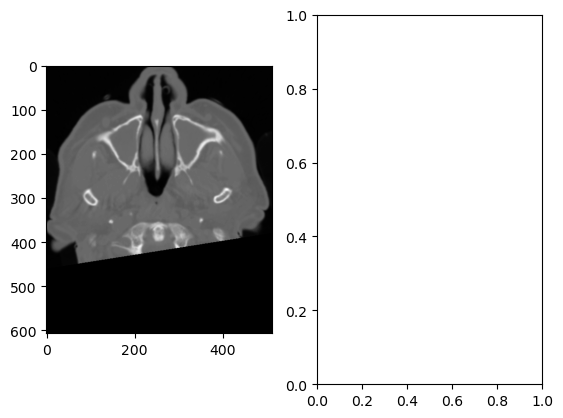

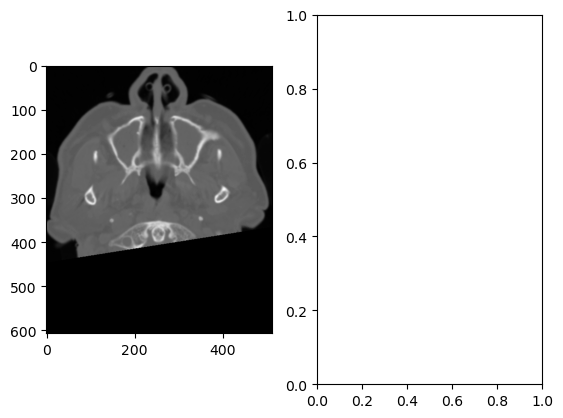

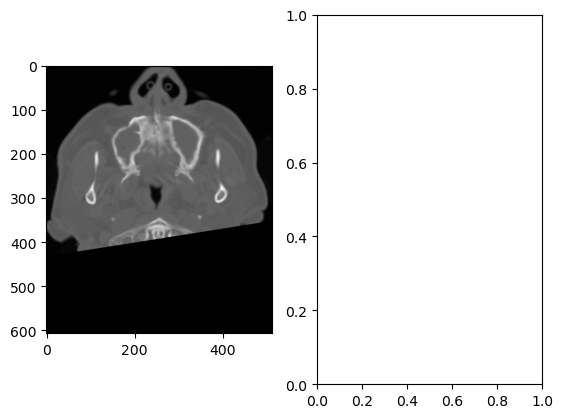

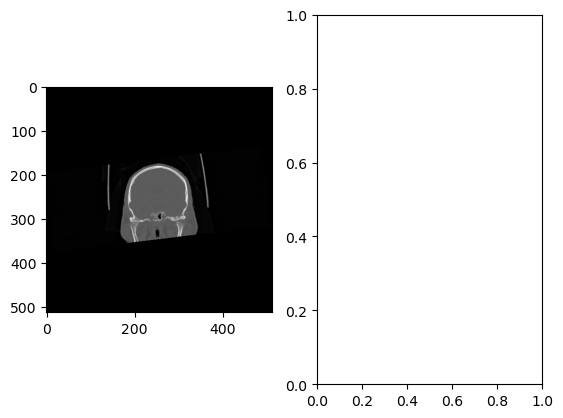

In [162]:
for i, s in enumerate(ct_scan):
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(s.pixel_array, cmap="gray")
    # axarr[1].imshow(data[:, :, i], cmap="gray")
    plt.show()

53


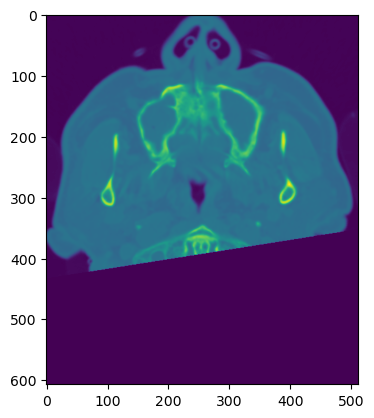

In [163]:
# Takes in DICOM image returns orientation
def check_orientation(ct_scan): 
    image_ori = ct_scan.ImageOrientationPatient
    image_y = np.array([image_ori[0], image_ori[1], image_ori[2]])
    image_x = np.array([image_ori[3], image_ori[4], image_ori[5]])
    image_z = np.cross(image_x, image_y)
    abs_image_z = abs(image_z)
    main_index = list(abs_image_z).index(max(abs_image_z))
    if main_index == 0:
        main_direction = "sagittal"
    elif main_index == 1:
        main_direction = "coronal"
    else:
        main_direction = "axial"
    return main_direction

slices = []
for i, s in enumerate(ct_scan):
    if check_orientation(s) == "axial":
        slices.append(s)
    else:
        print(i)
        
        
data_matrix = np.stack([s.pixel_array for s in slices], axis=2)

plt.imshow(ct_scan[52].pixel_array)

In [164]:
data_matrix.shape

(607, 512, 53)

In [165]:
nrrd.write("./temp/temp.nrrd", data_matrix)

In [166]:
data, header = nrrd.read("./temp/temp.nrrd")
print(data.shape)

(607, 512, 53)


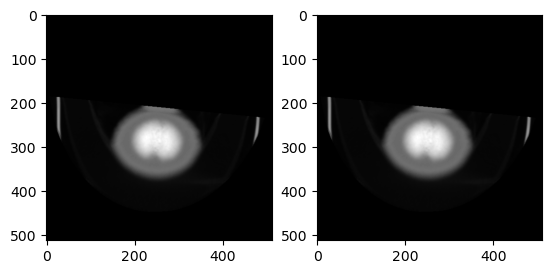

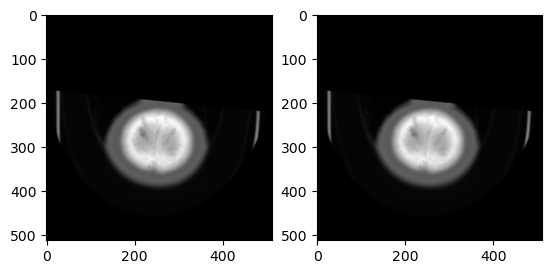

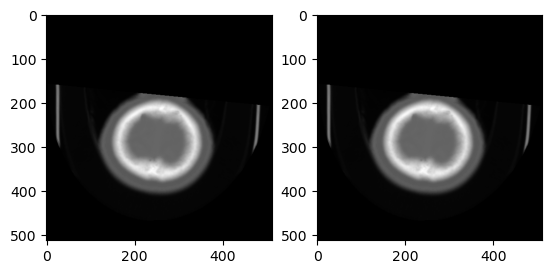

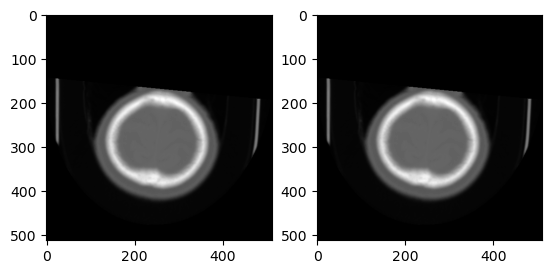

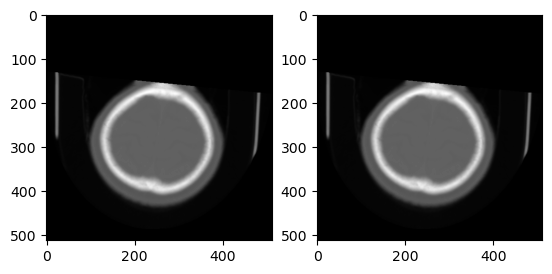

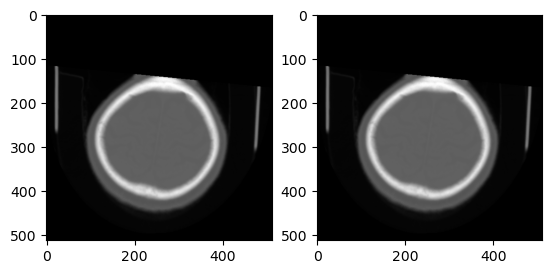

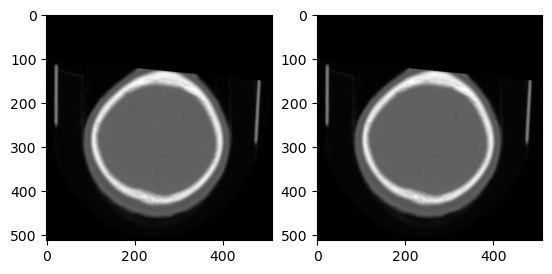

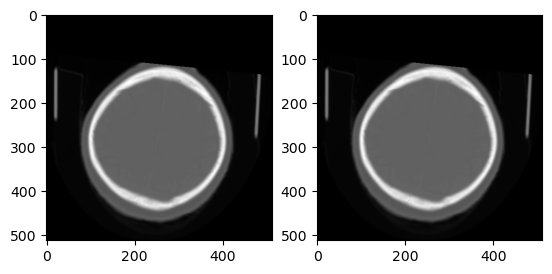

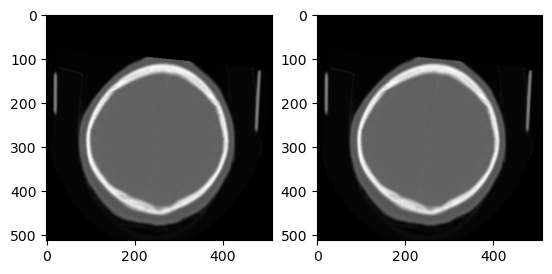

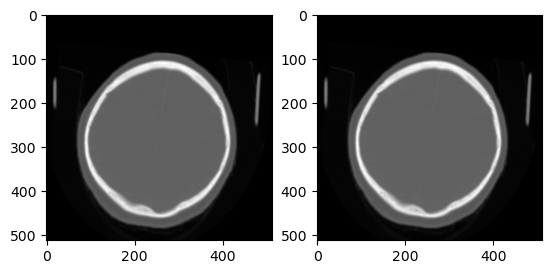

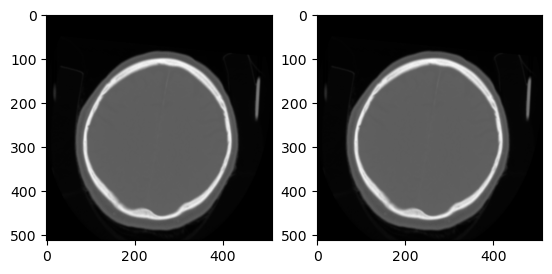

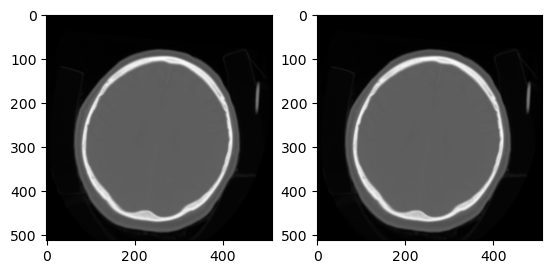

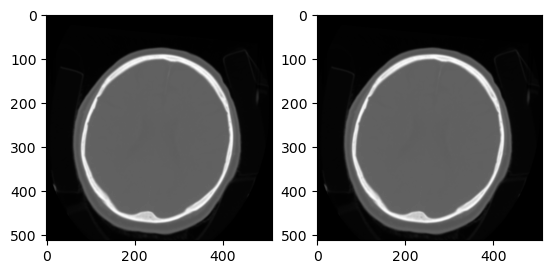

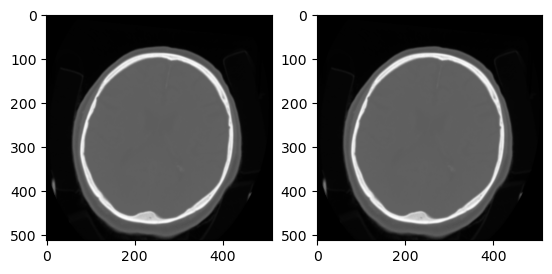

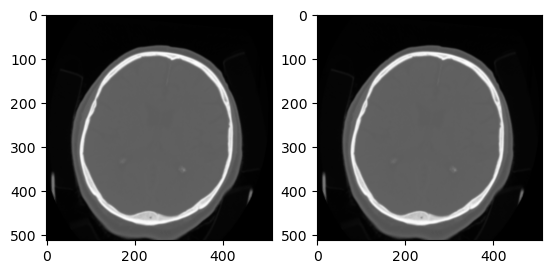

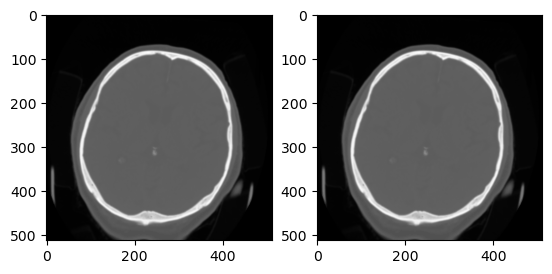

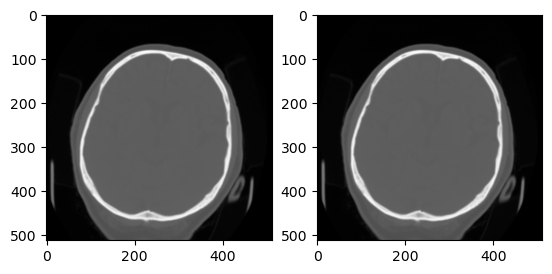

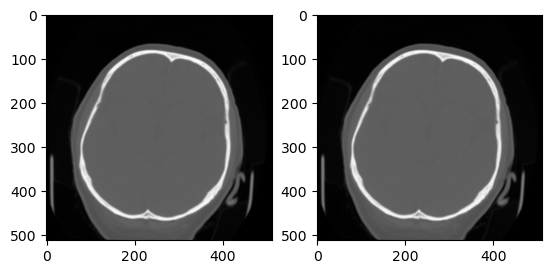

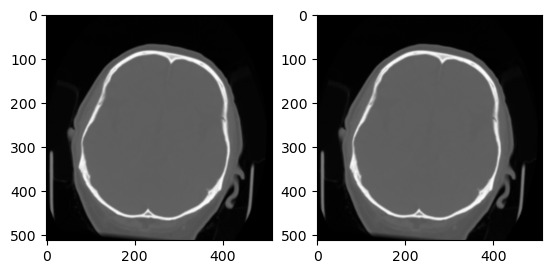

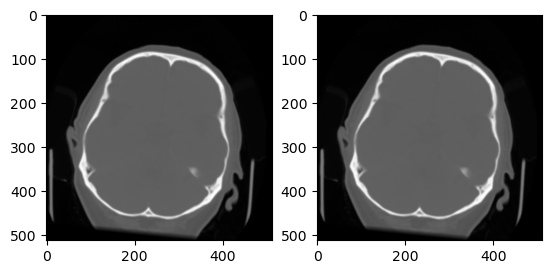

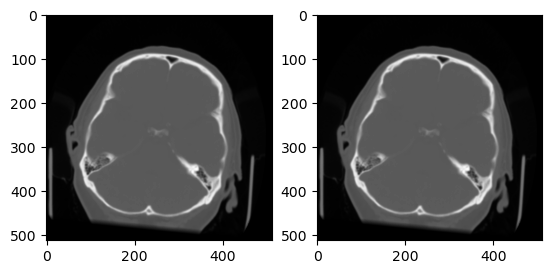

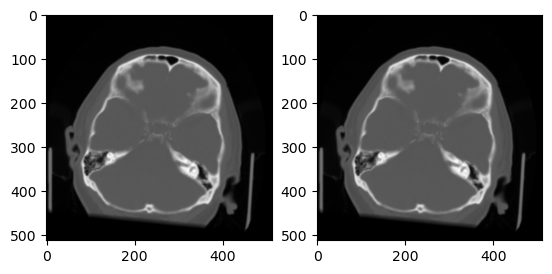

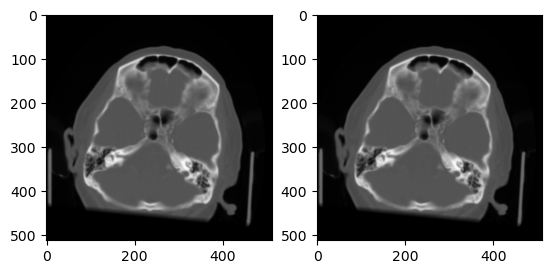

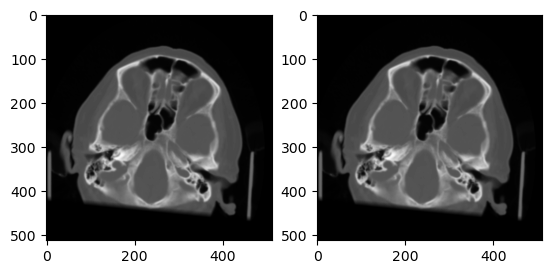

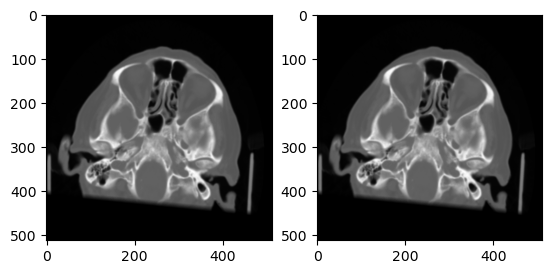

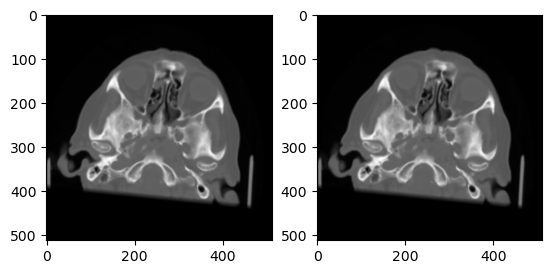

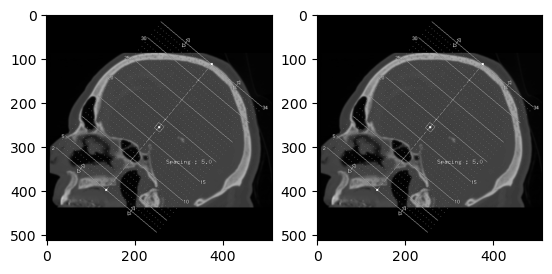

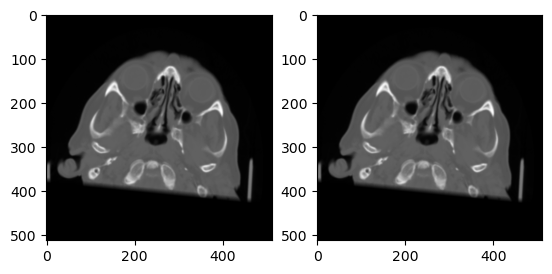

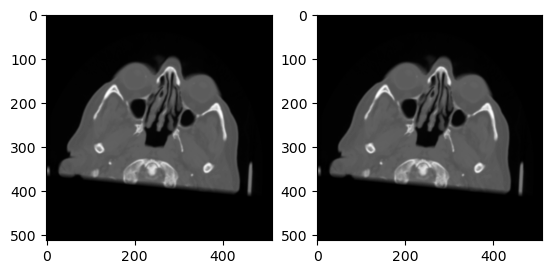

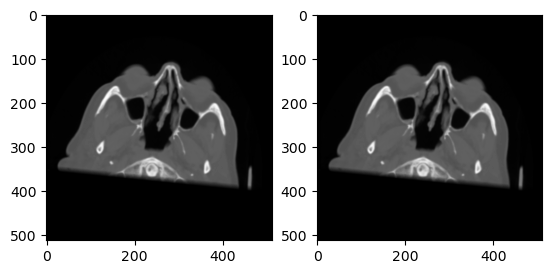

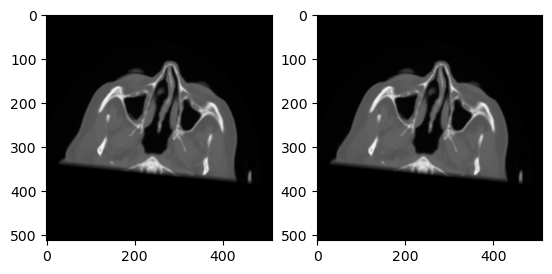

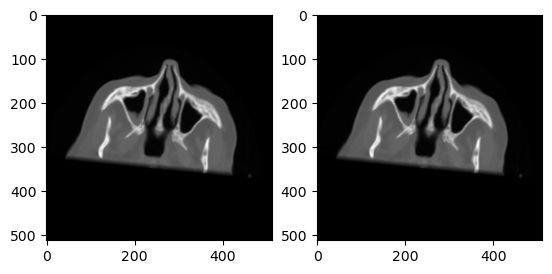

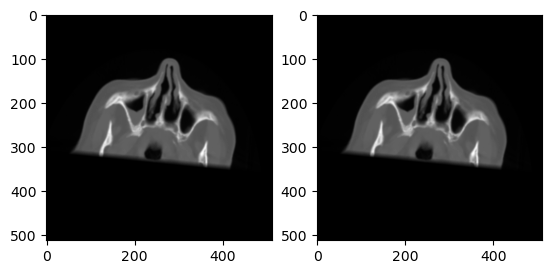

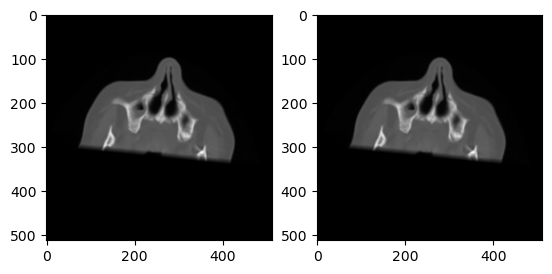

In [68]:
for i, s in enumerate(ct_scan):
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(s.pixel_array, cmap="gray")
    axarr[1].imshow(data[:, :, i], cmap="gray")
    plt.show()

False


Traceback (most recent call last):
  File "/home/npanchal/osteoporosis_ct/DeepContrast/run_inference.py", line 3, in <module>
    from prediction.data_prepro import data_prepro
  File "/home/npanchal/osteoporosis_ct/DeepContrast/prediction/data_prepro.py", line 5, in <module>
    import pandas as pd
ModuleNotFoundError: No module named 'pandas'


1